In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import gmplot
import torch
from torch import nn
from tqdm import tqdm
from tqdm import trange
import h3
from collections import OrderedDict
from sklearn.preprocessing import  OneHotEncoder
import torch.nn.functional as F


In [2]:

def dataset(user,start,end,step):

    userdata =  '../Geolife Trajectories 1.3/Data/'+user+'/Trajectory/'
    filelist = os.listdir(userdata)  #返回指定路径下所有文件和文件夹的名字，并存放于一个列表中
    filelist.sort()
    names = ['lat','lng','zero','alt','days','date','time']
    df_list = [# f为文件索引号，header为列数，names为列表列名，index_col为行索引的列编号或列名
    pd.read_csv(userdata + f,header=6,names=names,index_col=False)
    for f in filelist[start:end]]
    df = pd.concat(df_list, ignore_index=True) #表格列字段不同的表合并
    df.drop(['zero', 'days'], axis=1, inplace=True) #drop函数默认删除行，列需要加axis = 1
    df_min = df.iloc[::step, :]
    return df_min
def synthetic_data(df_min):
    a =df_min['lat'].tolist()
    b = df_min['lng'].tolist()
    a = torch.tensor(a,dtype=torch.float,requires_grad=True).reshape((-1, 1))
    b = torch.tensor(b,dtype=torch.float,requires_grad=True).reshape((-1, 1))
    features = torch.concat([a,b],1)
    return features
#返回（经度，纬度） shape：torch.Size([368, 2])

# 这个提取出来有5个维度
train_dataset = dataset("006",0,20,20)
test_dataset =  dataset("006",20,25,20)
# 这个提取出来有2个维度
train_data = synthetic_data(train_dataset)
test_data = synthetic_data(test_dataset)
all_data =torch.concat([train_data,test_data],0)





def draw(list,number,b,k):
    new_list = torch.tensor(list)
    lat = []
    lng = []
    for i in new_list:
        lat.append(i[0])
        lng.append(i[1])
    old_lat = torch.stack(lat[:k-1])
    old_lng =torch.stack(lng[:k-1])
    print(old_lat)
    print(old_lng)
    lat_predict = (lat[k-1:])
    lng_predict = (lng[k-1:])
    print(lat_predict)
    print(lng_predict)
    lat = torch.stack(lat)
    lng =torch.stack(lng)
    gmap = gmplot.GoogleMapPlotter(lat[0], lng[0], b)
    gmap.plot(lat, lng,color='b',lw=20)  #描绘轨迹点
    gmap.plot(lat_predict, lng_predict,color='r',lw=20)  #描绘轨迹点
    gmap.draw("user{}.html".format(number))   #显示图
    print("over")
def geo_t_h3_norepeat(data):
        h3_list =OrderedDict()
        for i in data:
            a = h3.geo_to_h3(i[0], i[1], 10)
            # print(a)
            h3_list.setdefault(a)
        #这这里去掉h3的重复
        return h3_list
def h3_t_geo(data):
    new_list = []
    for i in data:
        i =h3.h3_to_geo(i)
        new_list.append(i)
    return new_list
def generate_h3_list(data,label='repeat'):
    if label=='no-repeat':
        #不可重复的
        alist = geo_t_h3_norepeat(data)
        # print(type(alist))
        LIST = list(alist.keys())
        return np.array(LIST)
    elif label=='repeat':
        LIST=[]
        for temp in data:
            LIST.append(h3.geo_to_h3(temp[0],temp[1],10))
        return np.array(LIST)
    else:
        return np.array([])
    
    
    
# 搞一个批量训练的模型

In [3]:
Train_h3_list  = generate_h3_list(train_data,label='repeat')
Test_h3_list   = generate_h3_list(test_data,label='repeat')
#这个词典
vocab = generate_h3_list(all_data,label='no-repeat')

encoder = OneHotEncoder(sparse=False).fit(vocab.reshape(-1,1))


def encoding(data):
    return encoder.transform(data.reshape(-1,1))
def decoding(one_hot_data):
    return encoder.inverse_transform(one_hot_data)


# 可以通过idnex找到对应的h3
index_h  = dict(enumerate(vocab))
# 可以通过h3编码找到对应的index
h_index ={h3:i for i ,h3 in index_h.items()}


def label_encode(data):
    return np.array([h_index[ch] for ch in data])
def label_decode(data):
    return np.array([index_h[ch] for ch in data])




In [4]:
#y是一个列表，k是步长
def dataloader(y,k):
    data =[]
    for i in range(len(y)-k+1):
        indata = y[i:i+k]
        outdata = y[i+k:i+k+1]
        data.append((indata,outdata))
    return data

# def test_dataloader(y,k):

train_dataloader = dataloader(Train_h3_list,10)
test_dataloader =dataloader(Test_h3_list,10)
#暂时不加批量训练
# def data_loader(dataset,batchsize,drop_last=True):
#     for i in range(0,len(dataset)-batchsize+1,batchsize):
#         batch = dataset[i:i+batchsize]
#         batch

In [5]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'
class RNN(nn.Module):
    def __init__(self,vocab) -> None:
        super().__init__()
        self.vocab = vocab
        self.model =nn.LSTM(
            input_size=vocab,
            hidden_size=320,
            batch_first=True,
            bias=True
        )

        self.output = nn.Sequential(
            nn.Linear(320,vocab)
            # nn.ReLU()
        )

    def forward(self,x):
        r_out,(h_out,c_out) = self.model(x.view(1,10,self.vocab) ,None)
        outdata = self.output(r_out[:,-1,:])
        return outdata
    # def forward(self, inputs, state):
    #     X = F.one_hot(inputs.T.long(), self.vocab_size)
    #     X = X.to(torch.float32)
    #     Y, state = self.rnn(X, state)
    #     # The fully connected layer will first change the shape of `Y` to
    #     # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
    #     # (`num_steps` * `batch_size`, `vocab_size`).
    #     output = self.linear(Y.reshape((-1, Y.shape[-1])))
    #     return output, state


net = RNN(len(vocab)).to(device)
net=nn.DataParallel(net)
optimizer = torch.optim.SGD(net.parameters(),lr = 0.1,momentum=0.8)
optimizer_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
loss_function = nn.CrossEntropyLoss()

  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\zhangliyu\.conda\envs\limuconda\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


--------------Epochs200 | 0---------------
Train Loss : 6890.24169921875


  0%|          | 1/200 [00:10<35:57, 10.84s/it]

Val Loss : 4269.48876953125


  1%|          | 2/200 [00:16<25:30,  7.73s/it]

--------------Epochs200 | 1---------------
Train Loss : 6085.83544921875


  2%|▏         | 3/200 [00:21<22:04,  6.72s/it]

--------------Epochs200 | 2---------------
Train Loss : 5658.580078125


  2%|▏         | 4/200 [00:28<21:31,  6.59s/it]

--------------Epochs200 | 3---------------
Train Loss : 5285.52294921875


  2%|▎         | 5/200 [00:34<21:18,  6.56s/it]

--------------Epochs200 | 4---------------
Train Loss : 5482.9169921875
--------------Epochs200 | 5---------------
Train Loss : 5174.73388671875


  3%|▎         | 6/200 [00:41<21:44,  6.72s/it]

Val Loss : 4978.63623046875


  4%|▎         | 7/200 [00:48<21:03,  6.55s/it]

--------------Epochs200 | 6---------------
Train Loss : 5060.25537109375


  4%|▍         | 8/200 [00:54<20:51,  6.52s/it]

--------------Epochs200 | 7---------------
Train Loss : 5028.72998046875


  4%|▍         | 9/200 [01:01<20:51,  6.55s/it]

--------------Epochs200 | 8---------------
Train Loss : 5118.19091796875


  5%|▌         | 10/200 [01:08<21:29,  6.79s/it]

--------------Epochs200 | 9---------------
Train Loss : 5081.669921875
--------------Epochs200 | 10---------------
Train Loss : 4904.21728515625


  6%|▌         | 11/200 [01:16<22:27,  7.13s/it]

Val Loss : 5007.83837890625


  6%|▌         | 12/200 [01:21<20:52,  6.66s/it]

--------------Epochs200 | 11---------------
Train Loss : 4697.98046875


  6%|▋         | 13/200 [01:27<19:27,  6.25s/it]

--------------Epochs200 | 12---------------
Train Loss : 4647.92626953125


  7%|▋         | 14/200 [01:32<18:38,  6.02s/it]

--------------Epochs200 | 13---------------
Train Loss : 4693.5888671875


  8%|▊         | 15/200 [01:38<18:20,  5.95s/it]

--------------Epochs200 | 14---------------
Train Loss : 5351.73974609375
--------------Epochs200 | 15---------------
Train Loss : 10122.0439453125


  8%|▊         | 16/200 [01:46<20:07,  6.56s/it]

Val Loss : 9712.21484375


  8%|▊         | 17/200 [01:52<19:12,  6.30s/it]

--------------Epochs200 | 16---------------
Train Loss : 9339.8984375


  9%|▉         | 18/200 [01:57<18:27,  6.09s/it]

--------------Epochs200 | 17---------------
Train Loss : 8639.0537109375


 10%|▉         | 19/200 [02:03<18:15,  6.05s/it]

--------------Epochs200 | 18---------------
Train Loss : 8387.6953125


 10%|█         | 20/200 [02:12<20:46,  6.93s/it]

--------------Epochs200 | 19---------------
Train Loss : 7406.18310546875
--------------Epochs200 | 20---------------
Train Loss : 6924.1376953125


 10%|█         | 21/200 [02:20<21:45,  7.29s/it]

Val Loss : 5885.255859375


 11%|█         | 22/200 [02:26<20:18,  6.84s/it]

--------------Epochs200 | 21---------------
Train Loss : 6879.08056640625


 12%|█▏        | 23/200 [02:32<18:55,  6.42s/it]

--------------Epochs200 | 22---------------
Train Loss : 6678.2001953125


 12%|█▏        | 24/200 [02:37<17:59,  6.14s/it]

--------------Epochs200 | 23---------------
Train Loss : 6685.74755859375


 12%|█▎        | 25/200 [02:43<17:20,  5.95s/it]

--------------Epochs200 | 24---------------
Train Loss : 6547.73876953125
--------------Epochs200 | 25---------------
Train Loss : 6393.1171875


 13%|█▎        | 26/200 [02:49<18:02,  6.22s/it]

Val Loss : 5360.79248046875


 14%|█▎        | 27/200 [02:55<17:14,  5.98s/it]

--------------Epochs200 | 26---------------
Train Loss : 6442.11474609375


 14%|█▍        | 28/200 [03:01<17:30,  6.11s/it]

--------------Epochs200 | 27---------------
Train Loss : 6325.36181640625


 14%|█▍        | 29/200 [03:07<17:18,  6.07s/it]

--------------Epochs200 | 28---------------
Train Loss : 6404.064453125


 15%|█▌        | 30/200 [03:13<17:13,  6.08s/it]

--------------Epochs200 | 29---------------
Train Loss : 6197.69677734375
--------------Epochs200 | 30---------------
Train Loss : 5998.2724609375


 16%|█▌        | 31/200 [03:21<18:26,  6.55s/it]

Val Loss : 4946.92529296875


 16%|█▌        | 32/200 [03:27<17:54,  6.40s/it]

--------------Epochs200 | 31---------------
Train Loss : 6127.79541015625


 16%|█▋        | 33/200 [03:34<18:01,  6.47s/it]

--------------Epochs200 | 32---------------
Train Loss : 5988.189453125


 17%|█▋        | 34/200 [03:40<17:45,  6.42s/it]

--------------Epochs200 | 33---------------
Train Loss : 6140.4716796875


 18%|█▊        | 35/200 [03:46<17:09,  6.24s/it]

--------------Epochs200 | 34---------------
Train Loss : 6017.5986328125
--------------Epochs200 | 35---------------
Train Loss : 5856.45703125


 18%|█▊        | 36/200 [03:53<17:35,  6.44s/it]

Val Loss : 5202.83251953125


 18%|█▊        | 37/200 [03:58<16:41,  6.14s/it]

--------------Epochs200 | 36---------------
Train Loss : 5865.16845703125


 19%|█▉        | 38/200 [04:04<16:08,  5.98s/it]

--------------Epochs200 | 37---------------
Train Loss : 5841.283203125


 20%|█▉        | 39/200 [04:09<15:41,  5.85s/it]

--------------Epochs200 | 38---------------
Train Loss : 5651.04931640625


 20%|██        | 40/200 [04:15<15:10,  5.69s/it]

--------------Epochs200 | 39---------------
Train Loss : 5224.919921875
--------------Epochs200 | 40---------------
Train Loss : 4973.3642578125


 20%|██        | 41/200 [04:22<16:10,  6.10s/it]

Val Loss : 6207.7265625


 21%|██        | 42/200 [04:27<15:37,  5.93s/it]

--------------Epochs200 | 41---------------
Train Loss : 4955.34130859375


 22%|██▏       | 43/200 [04:33<15:11,  5.81s/it]

--------------Epochs200 | 42---------------
Train Loss : 4898.54248046875


 22%|██▏       | 44/200 [04:39<15:29,  5.96s/it]

--------------Epochs200 | 43---------------
Train Loss : 4862.1748046875


 22%|██▎       | 45/200 [04:45<15:31,  6.01s/it]

--------------Epochs200 | 44---------------
Train Loss : 4807.59716796875
--------------Epochs200 | 45---------------
Train Loss : 4719.33984375


 23%|██▎       | 46/200 [04:52<16:08,  6.29s/it]

Val Loss : 5089.7763671875


 24%|██▎       | 47/200 [04:58<15:33,  6.10s/it]

--------------Epochs200 | 46---------------
Train Loss : 4540.75146484375


 24%|██▍       | 48/200 [05:03<15:11,  5.99s/it]

--------------Epochs200 | 47---------------
Train Loss : 4554.98681640625


 24%|██▍       | 49/200 [05:09<14:46,  5.87s/it]

--------------Epochs200 | 48---------------
Train Loss : 4702.697265625


 25%|██▌       | 50/200 [05:15<14:25,  5.77s/it]

--------------Epochs200 | 49---------------
Train Loss : 4599.14697265625
--------------Epochs200 | 50---------------
Train Loss : 4793.14111328125


 26%|██▌       | 51/200 [05:22<15:13,  6.13s/it]

Val Loss : 6386.73583984375


 26%|██▌       | 52/200 [05:27<14:39,  5.94s/it]

--------------Epochs200 | 51---------------
Train Loss : 4792.35595703125


 26%|██▋       | 53/200 [05:33<14:14,  5.81s/it]

--------------Epochs200 | 52---------------
Train Loss : 4697.43994140625


 27%|██▋       | 54/200 [05:38<13:54,  5.71s/it]

--------------Epochs200 | 53---------------
Train Loss : 4663.451171875


 28%|██▊       | 55/200 [05:44<14:01,  5.80s/it]

--------------Epochs200 | 54---------------
Train Loss : 4429.36181640625
--------------Epochs200 | 55---------------
Train Loss : 4445.16455078125


 28%|██▊       | 56/200 [05:52<15:27,  6.44s/it]

Val Loss : 5711.28857421875


 28%|██▊       | 57/200 [05:58<14:42,  6.17s/it]

--------------Epochs200 | 56---------------
Train Loss : 4528.0380859375


 29%|██▉       | 58/200 [06:03<14:12,  6.00s/it]

--------------Epochs200 | 57---------------
Train Loss : 4352.22998046875


 30%|██▉       | 59/200 [06:09<14:01,  5.97s/it]

--------------Epochs200 | 58---------------
Train Loss : 4415.80078125


 30%|███       | 60/200 [06:14<13:31,  5.80s/it]

--------------Epochs200 | 59---------------
Train Loss : 4376.39306640625
--------------Epochs200 | 60---------------
Train Loss : 4114.89697265625


 30%|███       | 61/200 [06:23<15:07,  6.53s/it]

Val Loss : 4320.86474609375


 31%|███       | 62/200 [06:28<14:30,  6.31s/it]

--------------Epochs200 | 61---------------
Train Loss : 4088.471923828125


 32%|███▏      | 63/200 [06:35<14:28,  6.34s/it]

--------------Epochs200 | 62---------------
Train Loss : 4076.10888671875


 32%|███▏      | 64/200 [06:41<14:16,  6.30s/it]

--------------Epochs200 | 63---------------
Train Loss : 4106.7490234375


 32%|███▎      | 65/200 [06:47<13:49,  6.15s/it]

--------------Epochs200 | 64---------------
Train Loss : 4095.869873046875
--------------Epochs200 | 65---------------
Train Loss : 4019.665283203125


 33%|███▎      | 66/200 [06:54<14:33,  6.52s/it]

Val Loss : 4711.15380859375


 34%|███▎      | 67/200 [07:00<13:50,  6.24s/it]

--------------Epochs200 | 66---------------
Train Loss : 4031.39697265625


 34%|███▍      | 68/200 [07:06<13:26,  6.11s/it]

--------------Epochs200 | 67---------------
Train Loss : 3878.674560546875


 34%|███▍      | 69/200 [07:11<13:04,  5.99s/it]

--------------Epochs200 | 68---------------
Train Loss : 3872.202392578125


 35%|███▌      | 70/200 [07:17<12:52,  5.94s/it]

--------------Epochs200 | 69---------------
Train Loss : 3957.339111328125
--------------Epochs200 | 70---------------
Train Loss : 3894.28662109375


 36%|███▌      | 71/200 [07:24<13:28,  6.26s/it]

Val Loss : 4854.13916015625


 36%|███▌      | 72/200 [07:30<13:12,  6.19s/it]

--------------Epochs200 | 71---------------
Train Loss : 3781.486572265625


 36%|███▋      | 73/200 [07:36<13:06,  6.20s/it]

--------------Epochs200 | 72---------------
Train Loss : 3681.25146484375


 37%|███▋      | 74/200 [07:42<12:54,  6.14s/it]

--------------Epochs200 | 73---------------
Train Loss : 3607.408447265625


 38%|███▊      | 75/200 [07:49<12:54,  6.20s/it]

--------------Epochs200 | 74---------------
Train Loss : 3603.7275390625
--------------Epochs200 | 75---------------
Train Loss : 3597.359375


 38%|███▊      | 76/200 [07:56<13:11,  6.38s/it]

Val Loss : 5043.34423828125


 38%|███▊      | 77/200 [08:01<12:31,  6.11s/it]

--------------Epochs200 | 76---------------
Train Loss : 3427.17919921875


 39%|███▉      | 78/200 [08:07<12:07,  5.96s/it]

--------------Epochs200 | 77---------------
Train Loss : 3431.927001953125


 40%|███▉      | 79/200 [08:12<11:42,  5.81s/it]

--------------Epochs200 | 78---------------
Train Loss : 3394.296630859375


 40%|████      | 80/200 [08:18<11:26,  5.72s/it]

--------------Epochs200 | 79---------------
Train Loss : 3448.91943359375
--------------Epochs200 | 80---------------
Train Loss : 3279.546142578125


 40%|████      | 81/200 [08:25<12:00,  6.06s/it]

Val Loss : 4960.49365234375


 41%|████      | 82/200 [08:30<11:33,  5.88s/it]

--------------Epochs200 | 81---------------
Train Loss : 3306.321533203125


 42%|████▏     | 83/200 [08:35<11:15,  5.77s/it]

--------------Epochs200 | 82---------------
Train Loss : 3217.56689453125


 42%|████▏     | 84/200 [08:41<11:00,  5.70s/it]

--------------Epochs200 | 83---------------
Train Loss : 3254.520751953125


 42%|████▎     | 85/200 [08:47<10:48,  5.64s/it]

--------------Epochs200 | 84---------------
Train Loss : 3232.14404296875
--------------Epochs200 | 85---------------
Train Loss : 3154.624755859375


 43%|████▎     | 86/200 [08:54<11:33,  6.08s/it]

Val Loss : 4937.6669921875


 44%|████▎     | 87/200 [08:59<11:17,  6.00s/it]

--------------Epochs200 | 86---------------
Train Loss : 3049.013427734375


 44%|████▍     | 88/200 [09:10<13:53,  7.44s/it]

--------------Epochs200 | 87---------------
Train Loss : 3075.3310546875


 44%|████▍     | 89/200 [09:16<12:54,  6.97s/it]

--------------Epochs200 | 88---------------
Train Loss : 3007.89111328125


 45%|████▌     | 90/200 [09:22<12:08,  6.62s/it]

--------------Epochs200 | 89---------------
Train Loss : 2963.2412109375
--------------Epochs200 | 90---------------
Train Loss : 2820.751708984375


 46%|████▌     | 91/200 [09:29<12:10,  6.71s/it]

Val Loss : 4943.529296875


 46%|████▌     | 92/200 [09:34<11:29,  6.39s/it]

--------------Epochs200 | 91---------------
Train Loss : 2755.08837890625


 46%|████▋     | 93/200 [09:40<11:06,  6.23s/it]

--------------Epochs200 | 92---------------
Train Loss : 2730.71923828125


 47%|████▋     | 94/200 [09:47<10:58,  6.21s/it]

--------------Epochs200 | 93---------------
Train Loss : 2691.304931640625


 48%|████▊     | 95/200 [09:52<10:31,  6.02s/it]

--------------Epochs200 | 94---------------
Train Loss : 2614.3759765625
--------------Epochs200 | 95---------------
Train Loss : 2591.392333984375


 48%|████▊     | 96/200 [09:59<10:54,  6.29s/it]

Val Loss : 4776.89892578125


 48%|████▊     | 97/200 [10:05<10:27,  6.09s/it]

--------------Epochs200 | 96---------------
Train Loss : 2632.703857421875


 49%|████▉     | 98/200 [10:11<10:19,  6.08s/it]

--------------Epochs200 | 97---------------
Train Loss : 2639.569091796875


 50%|████▉     | 99/200 [10:17<10:31,  6.26s/it]

--------------Epochs200 | 98---------------
Train Loss : 2565.979248046875


 50%|█████     | 100/200 [10:24<10:29,  6.29s/it]

--------------Epochs200 | 99---------------
Train Loss : 2646.681884765625
--------------Epochs200 | 100---------------
Train Loss : 2621.6171875


 50%|█████     | 101/200 [10:32<11:17,  6.85s/it]

Val Loss : 5517.373046875


 51%|█████     | 102/200 [10:38<10:42,  6.55s/it]

--------------Epochs200 | 101---------------
Train Loss : 2566.31298828125


 52%|█████▏    | 103/200 [10:45<10:45,  6.65s/it]

--------------Epochs200 | 102---------------
Train Loss : 2555.04541015625


 52%|█████▏    | 104/200 [10:50<10:14,  6.40s/it]

--------------Epochs200 | 103---------------
Train Loss : 2556.798095703125


 52%|█████▎    | 105/200 [10:56<09:48,  6.19s/it]

--------------Epochs200 | 104---------------
Train Loss : 2568.56982421875
--------------Epochs200 | 105---------------
Train Loss : 2500.18212890625


 53%|█████▎    | 106/200 [11:03<10:06,  6.46s/it]

Val Loss : 5664.255859375


 54%|█████▎    | 107/200 [11:09<09:46,  6.30s/it]

--------------Epochs200 | 106---------------
Train Loss : 2527.209716796875


 54%|█████▍    | 108/200 [11:15<09:22,  6.11s/it]

--------------Epochs200 | 107---------------
Train Loss : 2637.491943359375


 55%|█████▍    | 109/200 [11:21<09:10,  6.05s/it]

--------------Epochs200 | 108---------------
Train Loss : 2552.24560546875


 55%|█████▌    | 110/200 [11:27<09:11,  6.13s/it]

--------------Epochs200 | 109---------------
Train Loss : 2480.624267578125
--------------Epochs200 | 110---------------
Train Loss : 2484.34765625


 56%|█████▌    | 111/200 [11:35<09:51,  6.64s/it]

Val Loss : 5550.40966796875


 56%|█████▌    | 112/200 [11:41<09:18,  6.34s/it]

--------------Epochs200 | 111---------------
Train Loss : 2439.185791015625


 56%|█████▋    | 113/200 [11:46<08:55,  6.15s/it]

--------------Epochs200 | 112---------------
Train Loss : 2370.487060546875


 57%|█████▋    | 114/200 [11:52<08:35,  5.99s/it]

--------------Epochs200 | 113---------------
Train Loss : 2333.458984375


 57%|█████▊    | 115/200 [11:58<08:20,  5.89s/it]

--------------Epochs200 | 114---------------
Train Loss : 2286.28515625
--------------Epochs200 | 115---------------
Train Loss : 2250.095703125


 58%|█████▊    | 116/200 [12:05<08:42,  6.22s/it]

Val Loss : 5602.3115234375


 58%|█████▊    | 117/200 [12:11<08:35,  6.21s/it]

--------------Epochs200 | 116---------------
Train Loss : 2209.224853515625


 59%|█████▉    | 118/200 [12:16<08:12,  6.01s/it]

--------------Epochs200 | 117---------------
Train Loss : 2161.310302734375


 60%|█████▉    | 119/200 [12:22<08:00,  5.93s/it]

--------------Epochs200 | 118---------------
Train Loss : 2150.5625


 60%|██████    | 120/200 [12:28<07:47,  5.85s/it]

--------------Epochs200 | 119---------------
Train Loss : 2235.106689453125
--------------Epochs200 | 120---------------
Train Loss : 2210.90380859375


 60%|██████    | 121/200 [12:39<09:43,  7.39s/it]

Val Loss : 5928.740234375


 61%|██████    | 122/200 [12:46<09:29,  7.30s/it]

--------------Epochs200 | 121---------------
Train Loss : 2184.877197265625


 62%|██████▏   | 123/200 [12:54<09:46,  7.62s/it]

--------------Epochs200 | 122---------------
Train Loss : 2164.9091796875


 62%|██████▏   | 124/200 [13:00<08:55,  7.05s/it]

--------------Epochs200 | 123---------------
Train Loss : 2151.84228515625


 62%|██████▎   | 125/200 [13:06<08:34,  6.86s/it]

--------------Epochs200 | 124---------------
Train Loss : 2142.17724609375
--------------Epochs200 | 125---------------
Train Loss : 2126.9345703125


 63%|██████▎   | 126/200 [13:13<08:32,  6.92s/it]

Val Loss : 5729.39404296875


 64%|██████▎   | 127/200 [13:19<08:03,  6.62s/it]

--------------Epochs200 | 126---------------
Train Loss : 2099.2373046875


 64%|██████▍   | 128/200 [13:30<09:17,  7.75s/it]

--------------Epochs200 | 127---------------
Train Loss : 2078.7041015625


 64%|██████▍   | 129/200 [13:41<10:30,  8.88s/it]

--------------Epochs200 | 128---------------
Train Loss : 2113.076416015625


 65%|██████▌   | 130/200 [13:48<09:39,  8.27s/it]

--------------Epochs200 | 129---------------
Train Loss : 2113.1435546875
--------------Epochs200 | 130---------------
Train Loss : 2057.3408203125


 66%|██████▌   | 131/200 [13:55<09:12,  8.01s/it]

Val Loss : 5815.2373046875


 66%|██████▌   | 132/200 [14:01<08:21,  7.37s/it]

--------------Epochs200 | 131---------------
Train Loss : 2024.9918212890625


 66%|██████▋   | 133/200 [14:07<07:41,  6.89s/it]

--------------Epochs200 | 132---------------
Train Loss : 2001.7149658203125


 67%|██████▋   | 134/200 [14:13<07:11,  6.53s/it]

--------------Epochs200 | 133---------------
Train Loss : 2194.49755859375


 68%|██████▊   | 135/200 [14:18<06:48,  6.29s/it]

--------------Epochs200 | 134---------------
Train Loss : 2080.25927734375
--------------Epochs200 | 135---------------
Train Loss : 2027.333740234375


 68%|██████▊   | 136/200 [14:26<07:08,  6.69s/it]

Val Loss : 5788.078125


 68%|██████▊   | 137/200 [14:33<07:00,  6.68s/it]

--------------Epochs200 | 136---------------
Train Loss : 1981.7449951171875


 69%|██████▉   | 138/200 [14:40<07:03,  6.82s/it]

--------------Epochs200 | 137---------------
Train Loss : 1959.2271728515625


 70%|██████▉   | 139/200 [14:49<07:44,  7.61s/it]

--------------Epochs200 | 138---------------
Train Loss : 1937.4891357421875


 70%|███████   | 140/200 [14:55<07:04,  7.08s/it]

--------------Epochs200 | 139---------------
Train Loss : 2019.6851806640625
--------------Epochs200 | 140---------------
Train Loss : 2003.693603515625


 70%|███████   | 141/200 [15:02<06:57,  7.08s/it]

Val Loss : 5588.44189453125


 71%|███████   | 142/200 [15:09<06:39,  6.88s/it]

--------------Epochs200 | 141---------------
Train Loss : 2017.1522216796875


 72%|███████▏  | 143/200 [15:14<06:08,  6.46s/it]

--------------Epochs200 | 142---------------
Train Loss : 1978.8453369140625


 72%|███████▏  | 144/200 [15:20<05:43,  6.14s/it]

--------------Epochs200 | 143---------------
Train Loss : 1950.4234619140625


 72%|███████▎  | 145/200 [15:25<05:30,  6.01s/it]

--------------Epochs200 | 144---------------
Train Loss : 1924.4149169921875
--------------Epochs200 | 145---------------
Train Loss : 1903.265869140625


 73%|███████▎  | 146/200 [15:35<06:23,  7.10s/it]

Val Loss : 5714.0234375


 74%|███████▎  | 147/200 [15:42<06:13,  7.04s/it]

--------------Epochs200 | 146---------------
Train Loss : 1888.9263916015625


 74%|███████▍  | 148/200 [15:49<06:02,  6.98s/it]

--------------Epochs200 | 147---------------
Train Loss : 1871.0828857421875


 74%|███████▍  | 149/200 [15:56<06:05,  7.16s/it]

--------------Epochs200 | 148---------------
Train Loss : 1856.3046875


 75%|███████▌  | 150/200 [16:03<05:45,  6.91s/it]

--------------Epochs200 | 149---------------
Train Loss : 1840.0977783203125
--------------Epochs200 | 150---------------
Train Loss : 1832.834716796875


 76%|███████▌  | 151/200 [16:10<05:41,  6.98s/it]

Val Loss : 5686.56103515625


 76%|███████▌  | 152/200 [16:15<05:15,  6.58s/it]

--------------Epochs200 | 151---------------
Train Loss : 1850.936279296875


 76%|███████▋  | 153/200 [16:21<04:56,  6.32s/it]

--------------Epochs200 | 152---------------
Train Loss : 1821.9046630859375


 77%|███████▋  | 154/200 [16:27<04:40,  6.10s/it]

--------------Epochs200 | 153---------------
Train Loss : 1823.93408203125


 78%|███████▊  | 155/200 [16:33<04:32,  6.05s/it]

--------------Epochs200 | 154---------------
Train Loss : 1802.981201171875
--------------Epochs200 | 155---------------
Train Loss : 1793.5740966796875


 78%|███████▊  | 156/200 [16:40<04:41,  6.39s/it]

Val Loss : 5867.2548828125


 78%|███████▊  | 157/200 [16:46<04:27,  6.22s/it]

--------------Epochs200 | 156---------------
Train Loss : 1776.763671875


 79%|███████▉  | 158/200 [16:51<04:13,  6.03s/it]

--------------Epochs200 | 157---------------
Train Loss : 1764.0455322265625


 80%|███████▉  | 159/200 [16:57<04:02,  5.92s/it]

--------------Epochs200 | 158---------------
Train Loss : 1754.1322021484375


 80%|████████  | 160/200 [17:03<03:56,  5.90s/it]

--------------Epochs200 | 159---------------
Train Loss : 1886.7689208984375
--------------Epochs200 | 160---------------
Train Loss : 1884.6776123046875


 80%|████████  | 161/200 [17:10<04:04,  6.28s/it]

Val Loss : 5864.7197265625


 81%|████████  | 162/200 [17:16<03:54,  6.18s/it]

--------------Epochs200 | 161---------------
Train Loss : 1875.5567626953125


 82%|████████▏ | 163/200 [17:22<03:45,  6.09s/it]

--------------Epochs200 | 162---------------
Train Loss : 1870.7242431640625


 82%|████████▏ | 164/200 [17:27<03:36,  6.00s/it]

--------------Epochs200 | 163---------------
Train Loss : 1865.512451171875


 82%|████████▎ | 165/200 [17:34<03:31,  6.05s/it]

--------------Epochs200 | 164---------------
Train Loss : 1865.34912109375
--------------Epochs200 | 165---------------
Train Loss : 1870.282958984375


 83%|████████▎ | 166/200 [17:41<03:38,  6.43s/it]

Val Loss : 5702.86083984375


 84%|████████▎ | 167/200 [17:47<03:32,  6.44s/it]

--------------Epochs200 | 166---------------
Train Loss : 1871.513671875


 84%|████████▍ | 168/200 [17:53<03:22,  6.33s/it]

--------------Epochs200 | 167---------------
Train Loss : 1879.0931396484375


 84%|████████▍ | 169/200 [18:00<03:14,  6.28s/it]

--------------Epochs200 | 168---------------
Train Loss : 1870.53857421875


 85%|████████▌ | 170/200 [18:06<03:09,  6.32s/it]

--------------Epochs200 | 169---------------
Train Loss : 1888.224853515625
--------------Epochs200 | 170---------------
Train Loss : 1901.6492919921875


 86%|████████▌ | 171/200 [18:14<03:18,  6.83s/it]

Val Loss : 5423.4189453125


 86%|████████▌ | 172/200 [18:21<03:10,  6.79s/it]

--------------Epochs200 | 171---------------
Train Loss : 1904.2191162109375


 86%|████████▋ | 173/200 [18:27<03:00,  6.67s/it]

--------------Epochs200 | 172---------------
Train Loss : 1935.2940673828125


 87%|████████▋ | 174/200 [18:34<02:56,  6.80s/it]

--------------Epochs200 | 173---------------
Train Loss : 1932.962890625


 88%|████████▊ | 175/200 [18:42<02:56,  7.05s/it]

--------------Epochs200 | 174---------------
Train Loss : 2107.56591796875
--------------Epochs200 | 175---------------
Train Loss : 2305.346923828125


 88%|████████▊ | 176/200 [18:50<02:57,  7.39s/it]

Val Loss : 5411.01318359375


 88%|████████▊ | 177/200 [18:56<02:42,  7.08s/it]

--------------Epochs200 | 176---------------
Train Loss : 2151.18359375


 89%|████████▉ | 178/200 [19:02<02:29,  6.78s/it]

--------------Epochs200 | 177---------------
Train Loss : 2239.77880859375


 90%|████████▉ | 179/200 [19:09<02:19,  6.65s/it]

--------------Epochs200 | 178---------------
Train Loss : 2191.36572265625


 90%|█████████ | 180/200 [19:15<02:11,  6.57s/it]

--------------Epochs200 | 179---------------
Train Loss : 2608.417236328125
--------------Epochs200 | 180---------------
Train Loss : 2612.795166015625


 90%|█████████ | 181/200 [19:23<02:12,  6.96s/it]

Val Loss : 5347.9384765625


 91%|█████████ | 182/200 [19:29<02:00,  6.67s/it]

--------------Epochs200 | 181---------------
Train Loss : 2627.801513671875


 92%|█████████▏| 183/200 [19:35<01:51,  6.55s/it]

--------------Epochs200 | 182---------------
Train Loss : 2943.38623046875


 92%|█████████▏| 184/200 [19:42<01:46,  6.63s/it]

--------------Epochs200 | 183---------------
Train Loss : 2938.6044921875


 92%|█████████▎| 185/200 [19:49<01:38,  6.60s/it]

--------------Epochs200 | 184---------------
Train Loss : 3024.655029296875
--------------Epochs200 | 185---------------
Train Loss : 2966.392822265625


 93%|█████████▎| 186/200 [19:56<01:36,  6.87s/it]

Val Loss : 5315.7626953125


 94%|█████████▎| 187/200 [20:03<01:27,  6.71s/it]

--------------Epochs200 | 186---------------
Train Loss : 2936.283935546875


 94%|█████████▍| 188/200 [20:09<01:18,  6.56s/it]

--------------Epochs200 | 187---------------
Train Loss : 2901.342041015625


 94%|█████████▍| 189/200 [20:15<01:10,  6.43s/it]

--------------Epochs200 | 188---------------
Train Loss : 2875.1015625


 95%|█████████▌| 190/200 [20:21<01:03,  6.31s/it]

--------------Epochs200 | 189---------------
Train Loss : 2873.852783203125
--------------Epochs200 | 190---------------
Train Loss : 2832.70361328125


 96%|█████████▌| 191/200 [20:29<01:00,  6.74s/it]

Val Loss : 5062.2138671875


 96%|█████████▌| 192/200 [20:35<00:53,  6.68s/it]

--------------Epochs200 | 191---------------
Train Loss : 2817.88916015625


 96%|█████████▋| 193/200 [20:41<00:45,  6.49s/it]

--------------Epochs200 | 192---------------
Train Loss : 2821.847412109375


 97%|█████████▋| 194/200 [20:47<00:37,  6.33s/it]

--------------Epochs200 | 193---------------
Train Loss : 2821.00244140625


 98%|█████████▊| 195/200 [20:53<00:30,  6.18s/it]

--------------Epochs200 | 194---------------
Train Loss : 2803.9228515625
--------------Epochs200 | 195---------------
Train Loss : 2788.936767578125


 98%|█████████▊| 196/200 [21:01<00:26,  6.62s/it]

Val Loss : 4964.5361328125


 98%|█████████▊| 197/200 [21:07<00:19,  6.57s/it]

--------------Epochs200 | 196---------------
Train Loss : 2767.548095703125


 99%|█████████▉| 198/200 [21:14<00:13,  6.59s/it]

--------------Epochs200 | 197---------------
Train Loss : 2752.4912109375


100%|█████████▉| 199/200 [21:20<00:06,  6.54s/it]

--------------Epochs200 | 198---------------
Train Loss : 2749.249755859375


100%|██████████| 200/200 [21:27<00:00,  6.44s/it]

--------------Epochs200 | 199---------------
Train Loss : 3046.6259765625


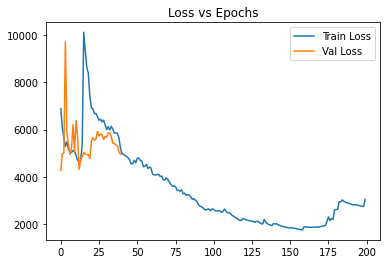

In [6]:
top_k = 5

epoches = 200



train_loss = []
test_acc = []


for epoch in trange(epoches):
    loss_ =0
    how_many_instance = 0
    val_loss_ =0
    optimizer_scheduler.step()
    optimizer.step()
    for i , k in train_dataloader[:-1]:
        optimizer.zero_grad()
        a = encoder.transform(i.reshape(-1,1))
        a =torch.tensor(a).to(torch.float32).to(device)
        k = label_encode(k)
        k =torch.tensor(k).to(torch.long).to(device)
        loss = loss_function(net(a),k)
        loss.backward()
        optimizer.step()
        loss_ = loss_+loss
        how_many_instance = how_many_instance + 1
    train_loss.append(loss_.cpu().detach().numpy() / how_many_instance)
    print(f'--------------Epochs{epoches} | {epoch}---------------')
    print(f'average Train Loss : {train_loss[-1]}')

    if(epoch%5==0):
        val_ls = 0
        how_many_instance = 0
        how_many_instance_right = 0
        with torch.no_grad():
            for i , k in test_dataloader[:-1]:
                a = encoder.transform(i.reshape(-1,1))
                a =torch.tensor(a).to(torch.float32).to(device)
                k = label_encode(k)
                k =torch.tensor(k).to(torch.long).to(device)#k的size确实是1，然后out的size是884的向量
                out = net(a)
                loss = loss_function(out,k)
                val_ls +=loss
                probs = F.softmax(out, dim=1).squeeze()
                probs, indices = probs.topk(5,largest=True) # 选取概率最大的前top_k个
                indices = indices.cpu().numpy()
                probs = probs.cpu().numpy()
                char_index = np.random.choice(indices,size=1, p = probs / probs.sum()) # 随机选取一个索引
                how_many_instance = how_many_instance +1
                if char_index == k:
                    how_many_instance_right = how_many_instance_right + 1

                #这个取索引的方法是取出前5个然后只根据这5个概率去看
                # h3_value = label_decode([char_index])
                # predict = h3_t_geo(h3_value.tolist())

        test_acc.append(how_many_instance_right / how_many_instance )
        print(f'test accuracy : { test_acc[-1]} ')



plt.plot(train_loss, label='Average Train Loss')
plt.plot(test_acc, label='test_acc')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()






In [7]:
top_k = 5
name_id = 1
with torch.no_grad():

    for i , k in test_dataloader[:-1]:


        a = encoder.transform(i.reshape(-1,1))
        a =torch.tensor(a).to(torch.float32).to(device)
        k = label_encode(k)
        k =torch.tensor(k).to(torch.long).to(device)
        out = net(a)
        loss = loss_function(out,k)
        probs = F.softmax(out, dim=1).squeeze()
        probs, indices = probs.topk(top_k) # 选取概率最大的前top_k个
        indices = indices.cpu().numpy()
        probs = probs.cpu().numpy()
        char_index = np.random.choice(indices, p = probs / probs.sum()) # 随机选取一个索引
        h3_value = label_decode([char_index])
        predict = h3_t_geo(h3_value.tolist())
        old=h3_t_geo(i.tolist())
        total_list = old+predict
        # print(total_list)
        draw(total_list,name_id,20,10)
        name_id+=1





[(39.98137390358118, 116.34317185914841), (39.98173344990935, 116.34206849815882), (39.98140648799353, 116.33991445203374), (39.98176601295398, 116.33881101147735), (39.98212553489541, 116.33770753646104), (39.98176601295398, 116.33881101147735), (39.981079476276854, 116.33776036111833), (39.98212553489541, 116.33770753646104), (39.98212553489541, 116.33770753646104), (39.981079476276854, 116.33776036111833), (39.98140648799353, 116.33991445203374)]
tensor([39.9814, 39.9817, 39.9814, 39.9818, 39.9821, 39.9818, 39.9811, 39.9821,
        39.9821])
tensor([116.3432, 116.3421, 116.3399, 116.3388, 116.3377, 116.3388, 116.3378,
        116.3377, 116.3377])
[tensor(39.9811), tensor(39.9814)]
[tensor(116.3378), tensor(116.3399)]
over
[(39.98173344990935, 116.34206849815882), (39.98140648799353, 116.33991445203374), (39.98176601295398, 116.33881101147735), (39.98212553489541, 116.33770753646104), (39.98176601295398, 116.33881101147735), (39.981079476276854, 116.33776036111833), (39.982125534895